In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
e_m_truck =L_truck.dot(estimated_truck_x)
print r2_score(m_car, L_car.dot(estimated_car_x))
print r2_score(m_truck, e_m_truck)import numpy as np
import pandas as pd
import sys
import datetime
import os
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import pickle
from collections import OrderedDict
import copy
from scipy.sparse import csr_matrix
from scipy import io
import seaborn as sns
import joblib
# from base import *
from joblib import Parallel, delayed
import random
import scipy

In [3]:
import matplotlib.pyplot as plt

from matplotlib import colors
import matplotlib
import six
import matplotlib.dates as mdates
import datetime
import pandas as pd
import seaborn as sns
sns.set()
plt.style.use('seaborn-poster')
from sklearn.metrics import r2_score

In [4]:
MNM_nb_folder = os.path.join('..', '..', '..', 'side_project', 'network_builder')
sys.path.append(MNM_nb_folder)
python_lib_folder = os.path.join('..', '..', 'pylib')
sys.path.append(python_lib_folder)

In [5]:
from MNMAPI import *
from MNM_mcnb import *
from mcDODE import *

In [6]:
data_folder = os.path.join('/home/lemma/Documents/MAC-POSTS/data/input_files_SR41_multiclass')

In [7]:
nb = MNM_network_builder()
nb.load_from_folder(data_folder)

In [8]:
num_interval = nb.config.config_dict['DTA']['max_interval']

In [9]:
true_car_f = np.random.rand(num_interval * nb.config.config_dict['FIXED']['num_path']) * 0.5
true_truck_f = np.random.rand(num_interval * nb.config.config_dict['FIXED']['num_path']) * 0.1
nb.update_demand_path2(true_car_f, true_truck_f)

In [10]:
# nb.dump_to_folder('testSR41')

In [11]:
usefuk_link_list = list(filter(lambda x: x.typ == 'CTM', nb.link_list))

In [12]:
num_observed_links = 500
observed_link_list = list(map(lambda x: x.ID, np.random.choice(usefuk_link_list, num_observed_links, replace=False)))

In [13]:
from sklearn.metrics import r2_score
from scipy import stats
def r2(predictions, targets):
    y_bar = np.mean(targets)
    # diff = np.minimum(np.abs(predictions - targets), targets)
    diff = predictions - targets
    ss_e = np.sum(diff ** 2)
    ss_t = np.sum((targets) ** 2)
    return 1 - ss_e / ss_t

def rsquared(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return r_value**2

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def rmsn(predictions, targets):
    return np.sqrt(np.sum((predictions - targets) ** 2) * len(predictions)) / np.sum(targets)

In [14]:
ml_car = num_observed_links
ml_truck = num_observed_links
data_dict = dict()
# num_interval = nb.config.config_dict['DTA']['max_interval']
# true_car_f = np.random.rand(num_interval * nb.config.config_dict['FIXED']['num_path']) * 300
# true_truck_f = np.random.rand(num_interval * nb.config.config_dict['FIXED']['num_path']) * 30
# true_car_f, true_truck_f, _, _, _, _ = pickle.load(open('final_use.pickle', 'r'))

L_car_one = np.eye(ml_car)
L_truck_one = np.eye(ml_truck)
# L_truck_one = np.random.randint(2, size = (ml_truck, len(observed_link_list)))
L_car = csr_matrix(scipy.linalg.block_diag(*[L_car_one for i in range(num_interval)]))
L_truck = csr_matrix(scipy.linalg.block_diag(*[L_truck_one for i in range(num_interval)]))

config = dict()
config['use_car_link_flow'] = True
config['use_truck_link_flow'] = True
config['use_car_link_tt'] = True
config['use_truck_link_tt'] = True
config['car_count_agg'] = True
config['truck_count_agg'] = True
config['link_car_flow_weight'] = 1
config['link_truck_flow_weight'] = 1
config['link_car_tt_weight'] = 0.0
config['link_truck_tt_weight'] = 0.0
config['num_data'] = 1
config['observed_links'] = observed_link_list
config['paths_list'] = range(nb.config.config_dict['FIXED']['num_path'])


config['compute_car_link_flow_loss'] = True
config['compute_truck_link_flow_loss'] = True
config['compute_car_link_tt_loss'] = True
config['compute_truck_link_tt_loss'] = True

dode = MCDODE(nb, config)
dta = dode._run_simulation(true_car_f, true_truck_f)
true_car_dar, true_truck_dar = dode.get_dar(dta, true_car_f, true_truck_f)

noise_level = 0.1
(true_dar_car, true_dar_truck) = dode.get_dar(dta, true_car_f, true_truck_f)
true_car_x = true_dar_car.dot(true_car_f)
true_truck_x = true_dar_truck.dot(true_truck_f)
data_dict['car_count_agg_L_list'] = list()
data_dict['truck_count_agg_L_list'] = list()
data_dict['car_link_flow'] = []
data_dict['truck_link_flow'] = []
data_dict['car_link_tt'] = []
data_dict['truck_link_tt'] = []
for i in range(config['num_data']):
    true_car_x = dta.get_link_car_inflow(np.arange(0, dode.num_loading_interval, dode.ass_freq), 
                  np.arange(0, dode.num_loading_interval, dode.ass_freq) + dode.ass_freq).flatten(order = 'F')
    true_truck_x = dta.get_link_truck_inflow(np.arange(0, dode.num_loading_interval, dode.ass_freq), 
                  np.arange(0, dode.num_loading_interval, dode.ass_freq) + dode.ass_freq).flatten(order = 'F')
#     true_car_tt = dta.get_car_link_tt_robust(np.arange(0, dode.num_loading_interval, dode.ass_freq),
#                              np.arange(0, dode.num_loading_interval, dode.ass_freq) + dode.ass_freq).flatten(order = 'F')
    true_car_tt = dta.get_car_link_tt(np.arange(0, dode.num_loading_interval, dode.ass_freq)).flatten(order = 'F')
    true_truck_tt = dta.get_truck_link_tt(np.arange(0, dode.num_loading_interval, dode.ass_freq)).flatten(order = 'F')
    m_car = L_car.dot(true_car_x)
    m_truck = L_truck.dot(true_truck_x)
    data_dict['car_count_agg_L_list'].append(L_car)
    data_dict['truck_count_agg_L_list'].append(L_truck)
    data_dict['car_link_flow'].append(m_car + np.random.uniform(-1, 1, m_car.shape) * noise_level * m_car)
    data_dict['truck_link_flow'].append(m_truck + np.random.uniform(-1, 1, m_truck.shape) * noise_level * m_truck)
    data_dict['car_link_tt'].append(true_car_tt + np.random.uniform(-1, 1, true_car_tt.shape) * noise_level * true_car_tt)
    data_dict['truck_link_tt'].append(true_truck_tt + np.random.uniform(-1, 1, true_truck_tt.shape) * noise_level * true_truck_tt)

In [15]:
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

In [15]:
dode = MCDODE(nb, config)

In [16]:
dode.add_data(data_dict)

In [18]:
(car_flow, truck_flow, l_list) = dode.estimate_path_flow(max_epoch = 100, car_step_size = 0.1, 
                                                         truck_step_size = 0.01, car_init_scale = 0.1, 
                                                          truck_init_scale = 0.01, adagrad = True)
print r2_score(car_flow, true_car_f), r2_score(truck_flow, true_truck_f)

Epoch: 0 Loss: 3508.16 truck_count_loss: 664.85|car_tt_loss: 0.0|car_count_loss: 2843.31|truck_tt_loss: 0.0|
Epoch: 1 Loss: 3118.25 truck_count_loss: 659.5|car_tt_loss: 0.0|car_count_loss: 2458.75|truck_tt_loss: 0.0|
Epoch: 2 Loss: 2683.34 truck_count_loss: 658.11|car_tt_loss: 0.0|car_count_loss: 2025.23|truck_tt_loss: 0.0|
Epoch: 3 Loss: 2279.72 truck_count_loss: 644.72|car_tt_loss: 0.0|car_count_loss: 1635.0|truck_tt_loss: 0.0|
Epoch: 4 Loss: 1928.95 truck_count_loss: 645.31|car_tt_loss: 0.0|car_count_loss: 1283.64|truck_tt_loss: 0.0|
Epoch: 5 Loss: 1685.56 truck_count_loss: 641.48|car_tt_loss: 0.0|car_count_loss: 1044.08|truck_tt_loss: 0.0|
Epoch: 6 Loss: 1635.61 truck_count_loss: 631.44|car_tt_loss: 0.0|car_count_loss: 1004.17|truck_tt_loss: 0.0|
Epoch: 7 Loss: 1568.41 truck_count_loss: 627.51|car_tt_loss: 0.0|car_count_loss: 940.9|truck_tt_loss: 0.0|
Epoch: 8 Loss: 1551.79 truck_count_loss: 620.15|car_tt_loss: 0.0|car_count_loss: 931.64|truck_tt_loss: 0.0|
Epoch: 9 Loss: 1506.34 t

Epoch: 76 Loss: 840.93 truck_count_loss: 181.0|car_tt_loss: 0.0|car_count_loss: 659.93|truck_tt_loss: 0.0|
Epoch: 77 Loss: 805.72 truck_count_loss: 181.91|car_tt_loss: 0.0|car_count_loss: 623.81|truck_tt_loss: 0.0|
Epoch: 78 Loss: 820.45 truck_count_loss: 177.37|car_tt_loss: 0.0|car_count_loss: 643.08|truck_tt_loss: 0.0|
Epoch: 79 Loss: 782.53 truck_count_loss: 175.37|car_tt_loss: 0.0|car_count_loss: 607.17|truck_tt_loss: 0.0|
Epoch: 80 Loss: 826.48 truck_count_loss: 178.24|car_tt_loss: 0.0|car_count_loss: 648.23|truck_tt_loss: 0.0|
Epoch: 81 Loss: 771.59 truck_count_loss: 173.9|car_tt_loss: 0.0|car_count_loss: 597.69|truck_tt_loss: 0.0|
Epoch: 82 Loss: 808.96 truck_count_loss: 174.69|car_tt_loss: 0.0|car_count_loss: 634.27|truck_tt_loss: 0.0|
Epoch: 83 Loss: 790.02 truck_count_loss: 174.35|car_tt_loss: 0.0|car_count_loss: 615.67|truck_tt_loss: 0.0|
Epoch: 84 Loss: 820.52 truck_count_loss: 174.24|car_tt_loss: 0.0|car_count_loss: 646.28|truck_tt_loss: 0.0|
Epoch: 85 Loss: 783.33 truck_c

In [19]:
pickle.dump([true_car_f, true_truck_f, car_flow, truck_flow, l_list, data_dict], open('final_use_SR41.pickle', 'w'))

In [20]:
color_list = ['teal', 'tomato', 'blue', 'sienna', 'plum', 'red', 'yellowgreen', 'khaki']
marker_list = ["o", "v", "^", "<", ">", "p", "D","*","s", "D", "p"]

In [21]:
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

In [22]:
_, _, car_flow, truck_flow, l_list, _ = pickle.load(open('final_use_SR41.pickle', 'r'))

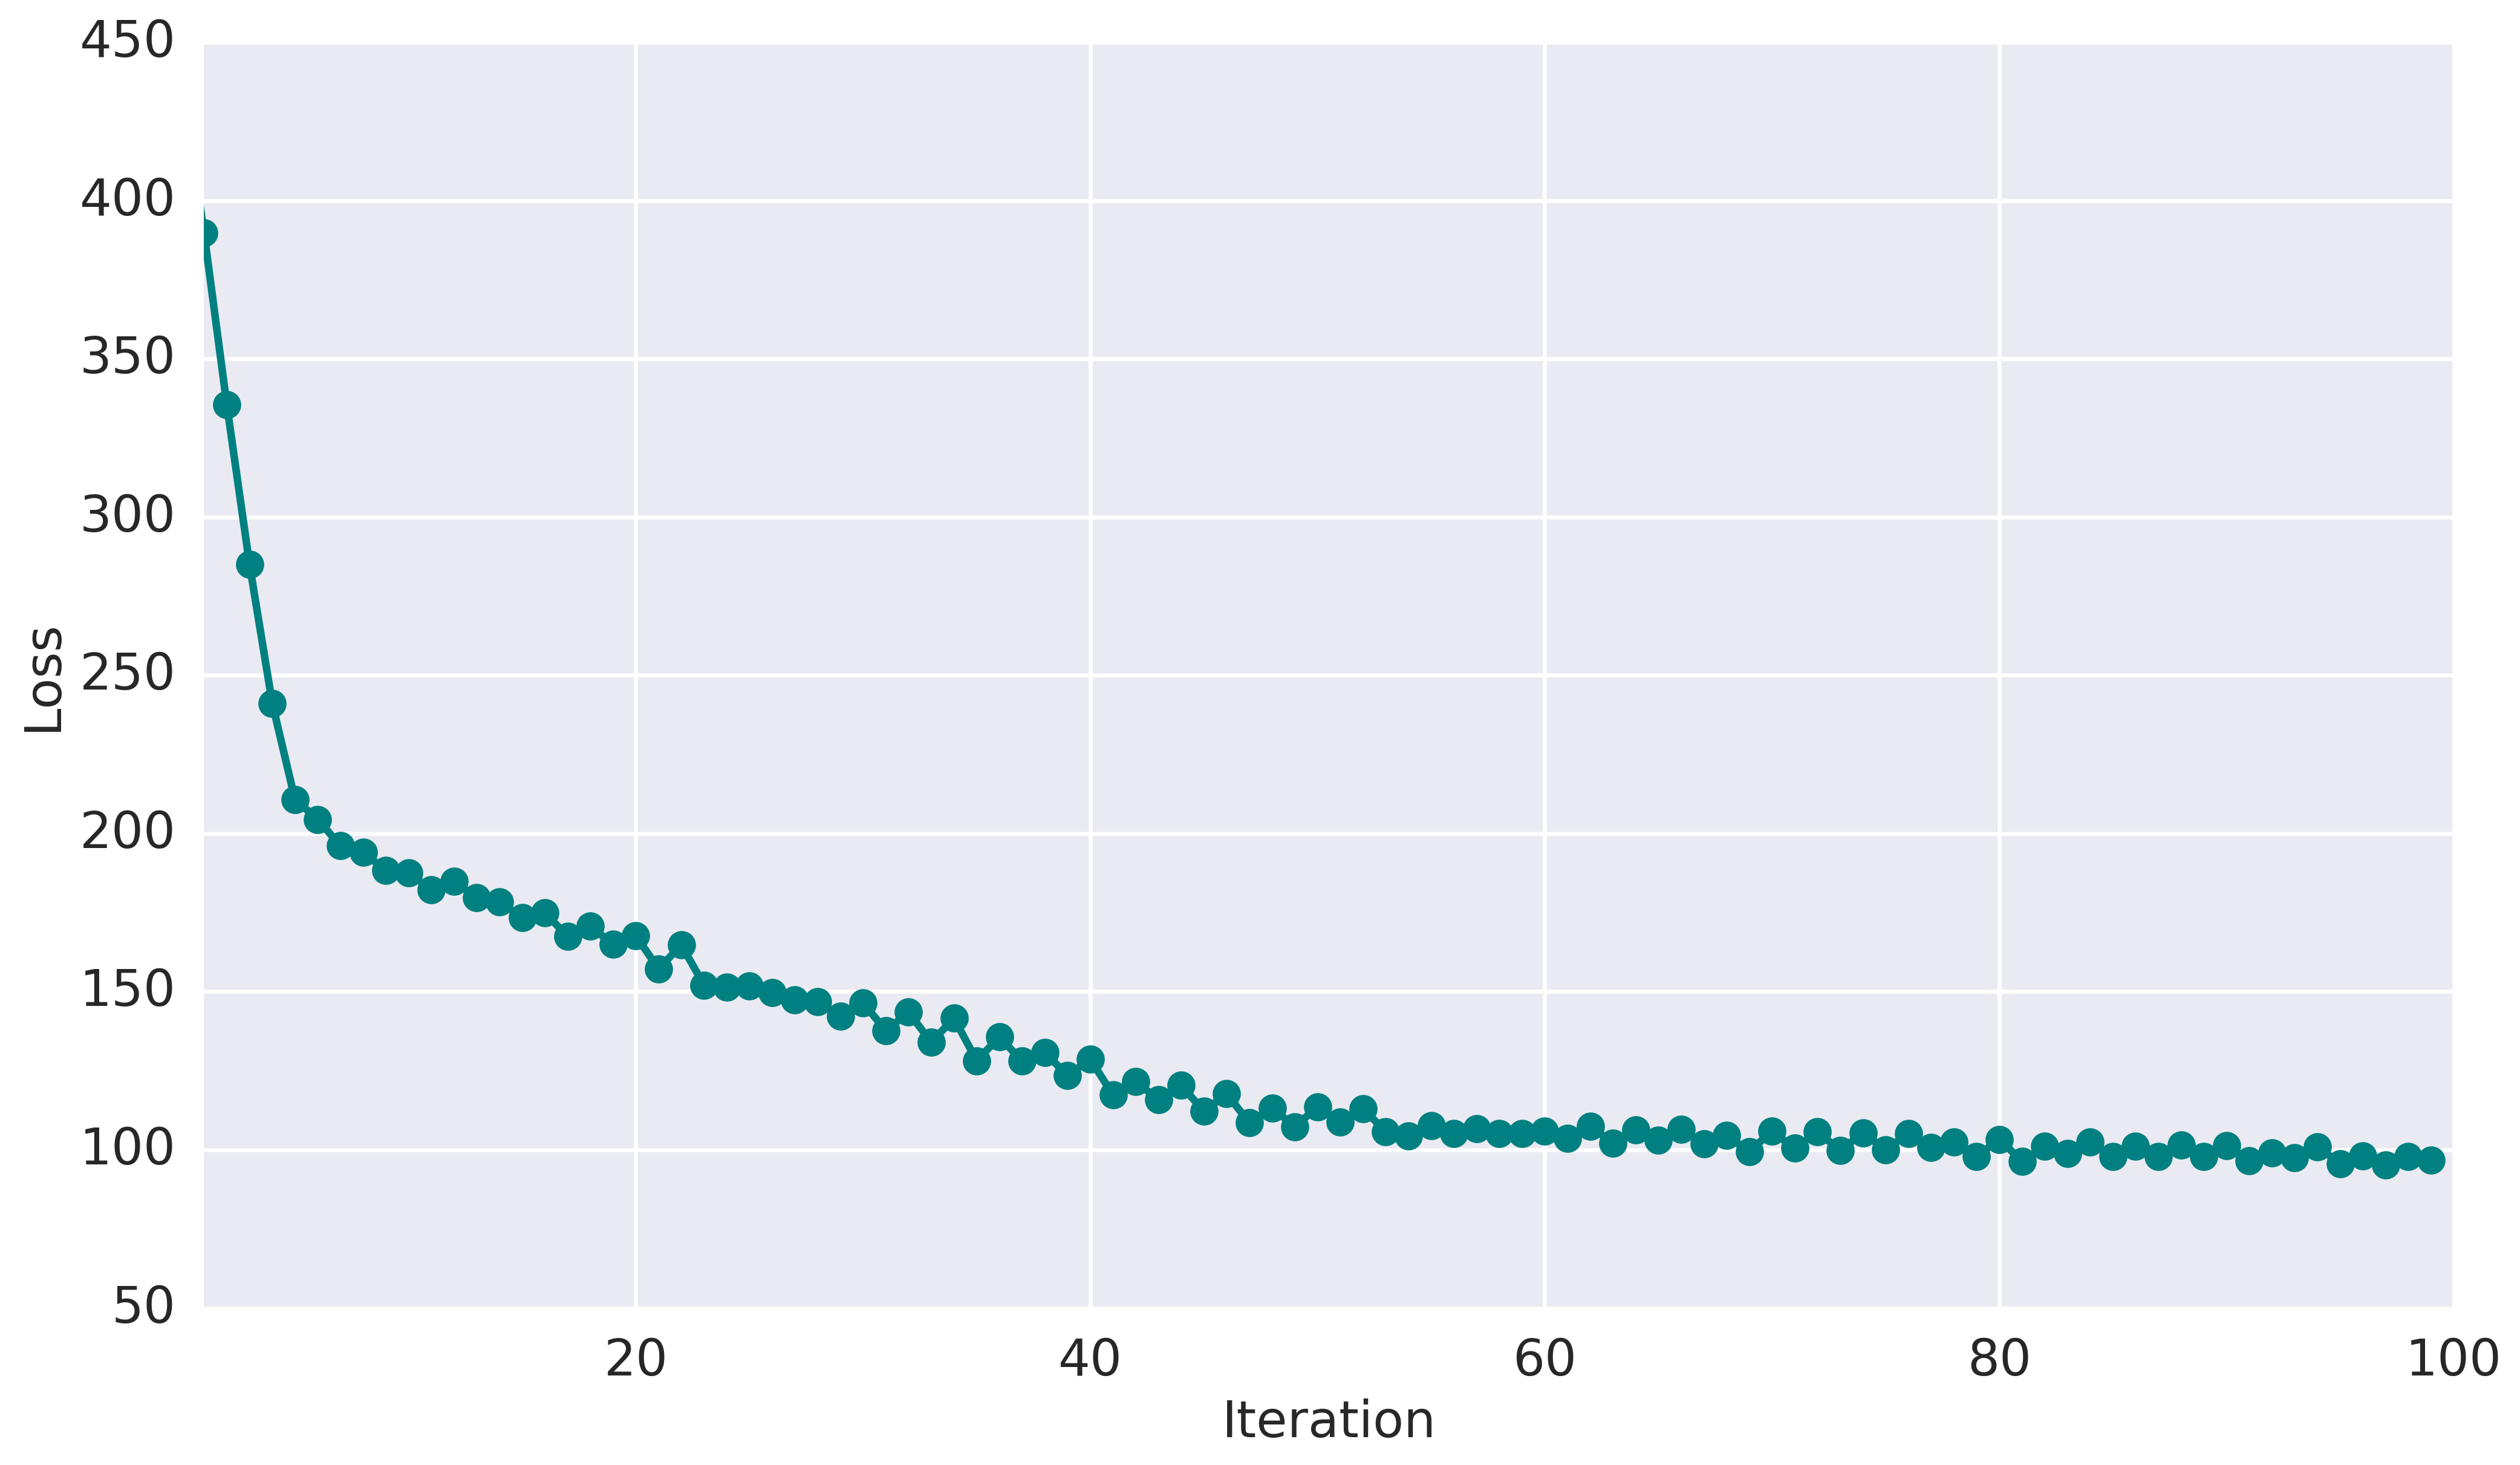

In [23]:
plt.figure(figsize = (16,9), dpi=300)
plt.plot(np.arange(len(l_list)), list(map(lambda x: x[0]/8, l_list)), 
         color = color_list[0], marker = 'o', linewidth = 3)
# plt.plot(range(len(l_list)), list(map(lambda x: x[0]/8, l_list)),
#          color = color_list[4], linewidth = 3, label = "Total cost")

plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Iteration', fontsize = 20)
# plt.legend()
# plt.ylim([0, 1])
plt.xlim([1, 100])
plt.show()

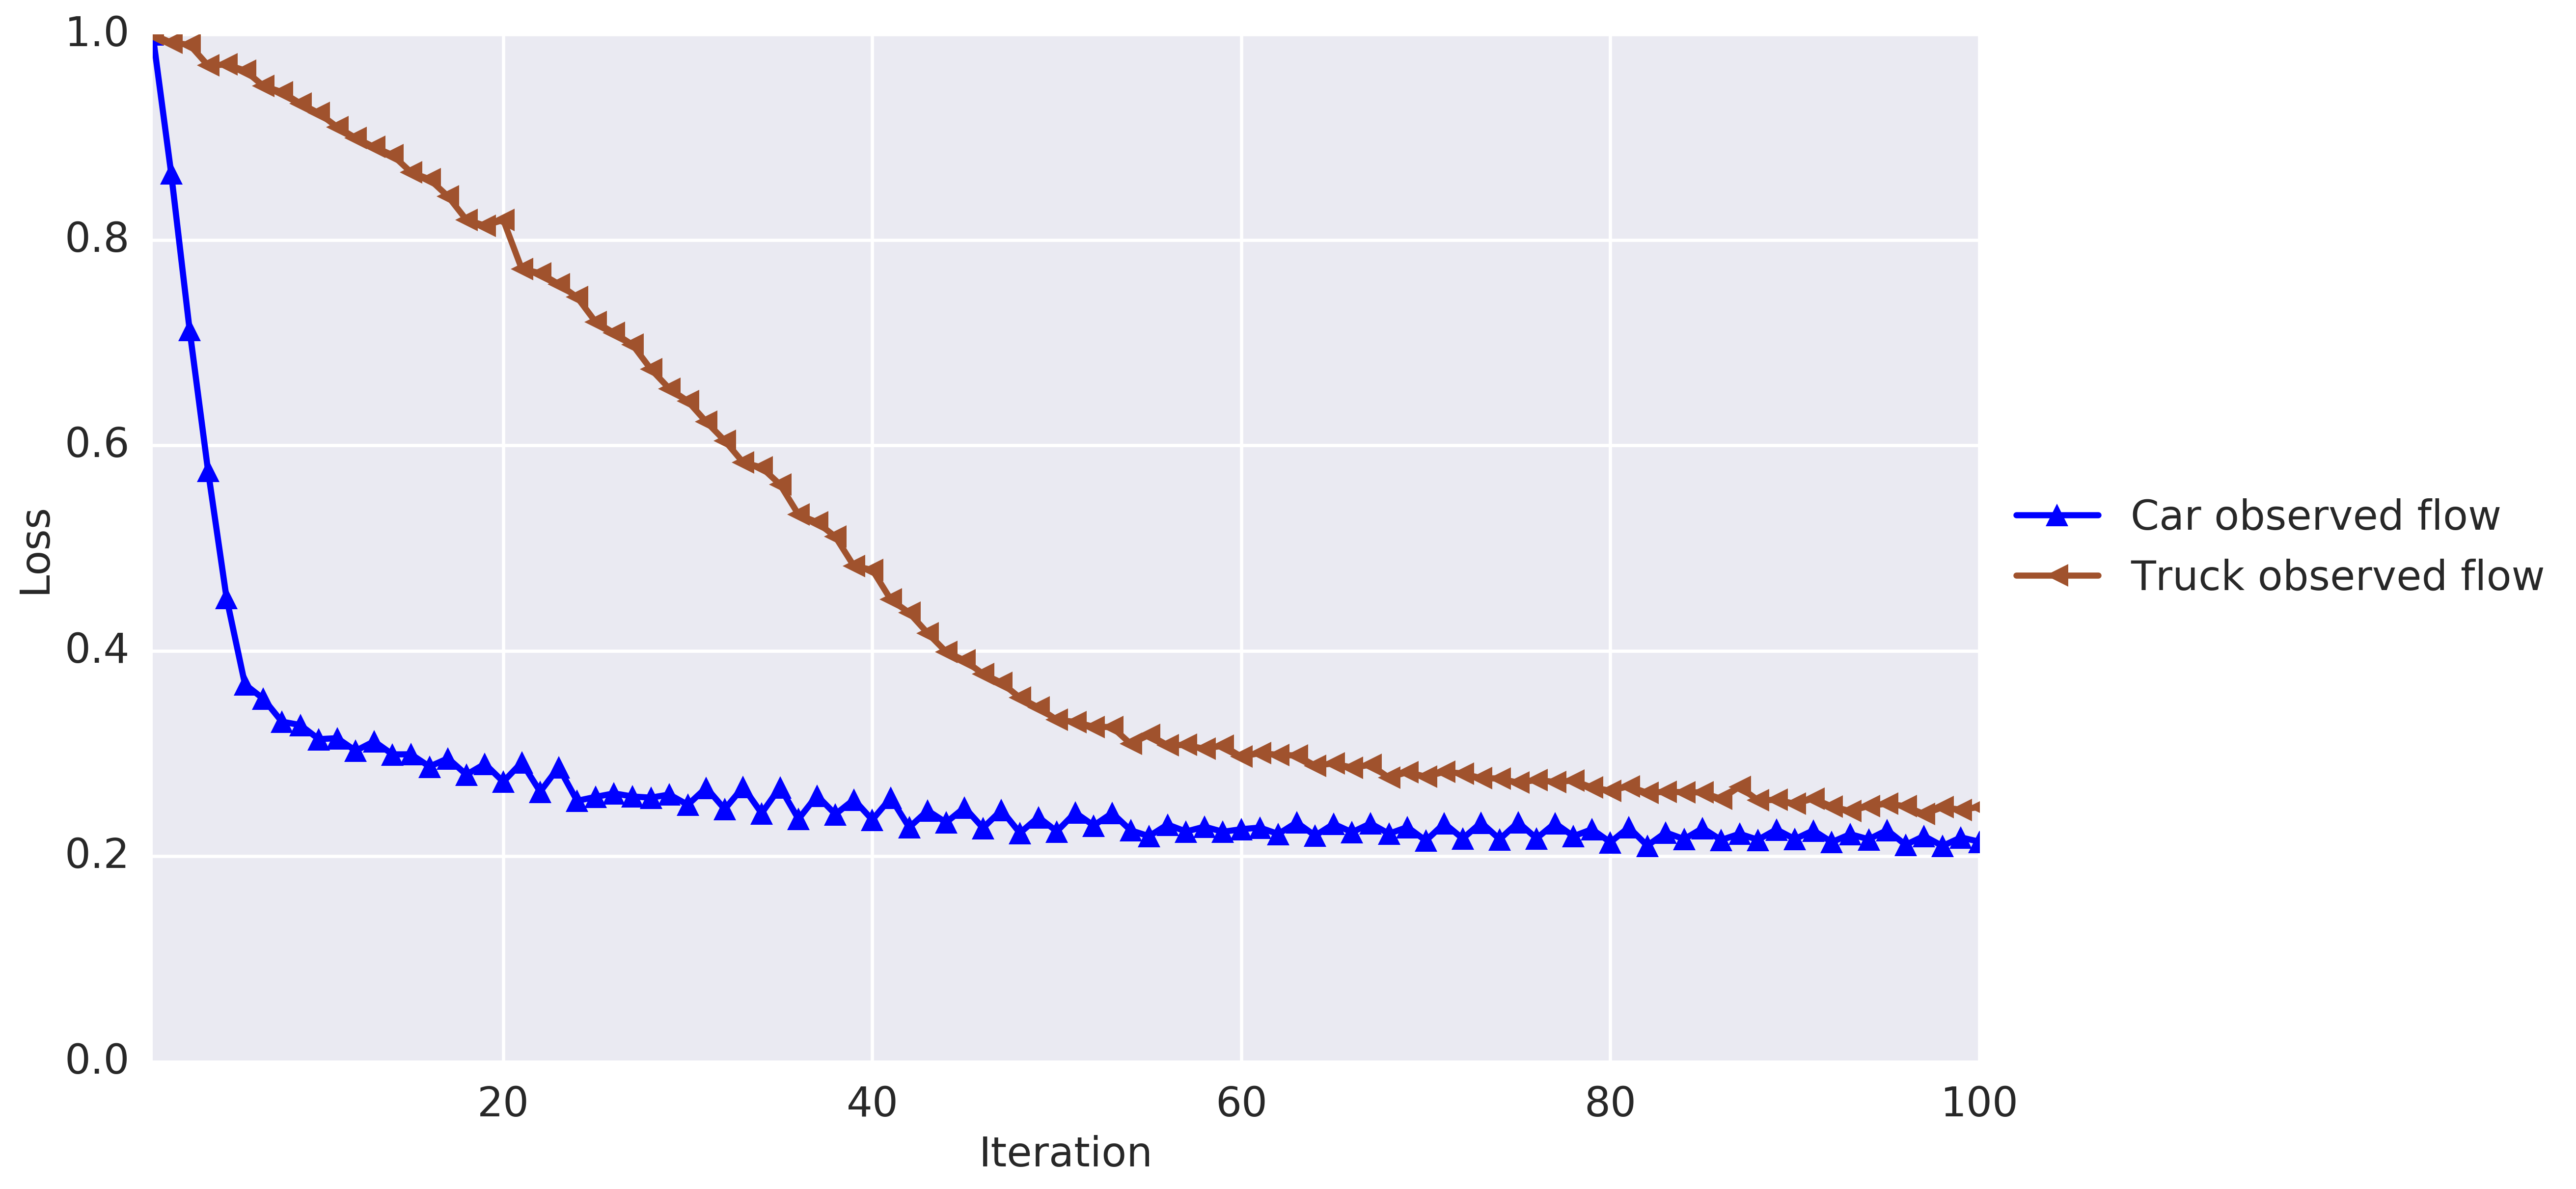

In [25]:
plt.figure(figsize = (16,9), dpi=300)
# plt.plot(np.arange(len(l_list))+1, list(map(lambda x: x[1]['truck_tt_loss']/l_list[0][1]['truck_tt_loss'], l_list)), 
#          color = color_list[0],  marker = marker_list[0], linewidth = 3, label = "Truck observed travel cost")
# plt.plot(np.arange(len(l_list))+1, list(map(lambda x: x[1]['car_tt_loss']/l_list[0][1]['car_tt_loss'], l_list)),
#          color = color_list[1],  marker = marker_list[1], linewidth = 3, label = "Car observed travel cost")
plt.plot(np.arange(len(l_list))+1, list(map(lambda x: x[1]['car_count_loss']/l_list[0][1]['car_count_loss'], l_list)),
         color = color_list[2],  marker = marker_list[2], linewidth = 3, label = "Car observed flow")
plt.plot(np.arange(len(l_list))+1, list(map(lambda x: x[1]['truck_count_loss']/l_list[0][1]['truck_count_loss'], l_list)),
         color = color_list[3], marker = marker_list[3], linewidth = 3, label = "Truck observed flow")
# plt.plot(range(len(l_list)), list(map(lambda x: x[0]/8, l_list)),
#          color = color_list[4], linewidth = 3, label = "Total cost")

plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([0, 1])
plt.xlim([1, 100])
plt.show()

In [36]:
# (car_flow, truck_flow, l_list) = dode.estimate_path_flow_mp(max_epoch = 200, step_size = 0.1, car_init_scale = 5, 
#                                                           truck_init_scale = 0.1, 
#                                                           adagrad = True, n_process = 8)

In [37]:
# (car_flow, truck_flow, l_list) = dode.estimate_path_flow(max_epoch = 200, step_size = 0.1, car_init_scale = 5, 
#                                                           truck_init_scale = 0.1, adagrad = True)

In [38]:
# plt.figure(figsize = (16,9), dpi=300)
# plt.plot(range(1,151), l_list, color = 'tomato', linewidth = 3)
# plt.ylabel('Loss')
# plt.xlabel('Iteration')
# plt.xlim([1, 150])
# plt.show()

In [26]:
dta = dode._run_simulation(true_car_f, truck_flow)
estimated_car_x = dta.get_link_car_inflow(np.arange(0, dode.num_loading_interval, dode.ass_freq), 
              np.arange(0, dode.num_loading_interval, dode.ass_freq) + dode.ass_freq).flatten(order = 'F')
estimated_truck_x = dta.get_link_truck_inflow(np.arange(0, dode.num_loading_interval, dode.ass_freq), 
              np.arange(0, dode.num_loading_interval, dode.ass_freq) + dode.ass_freq).flatten(order = 'F')

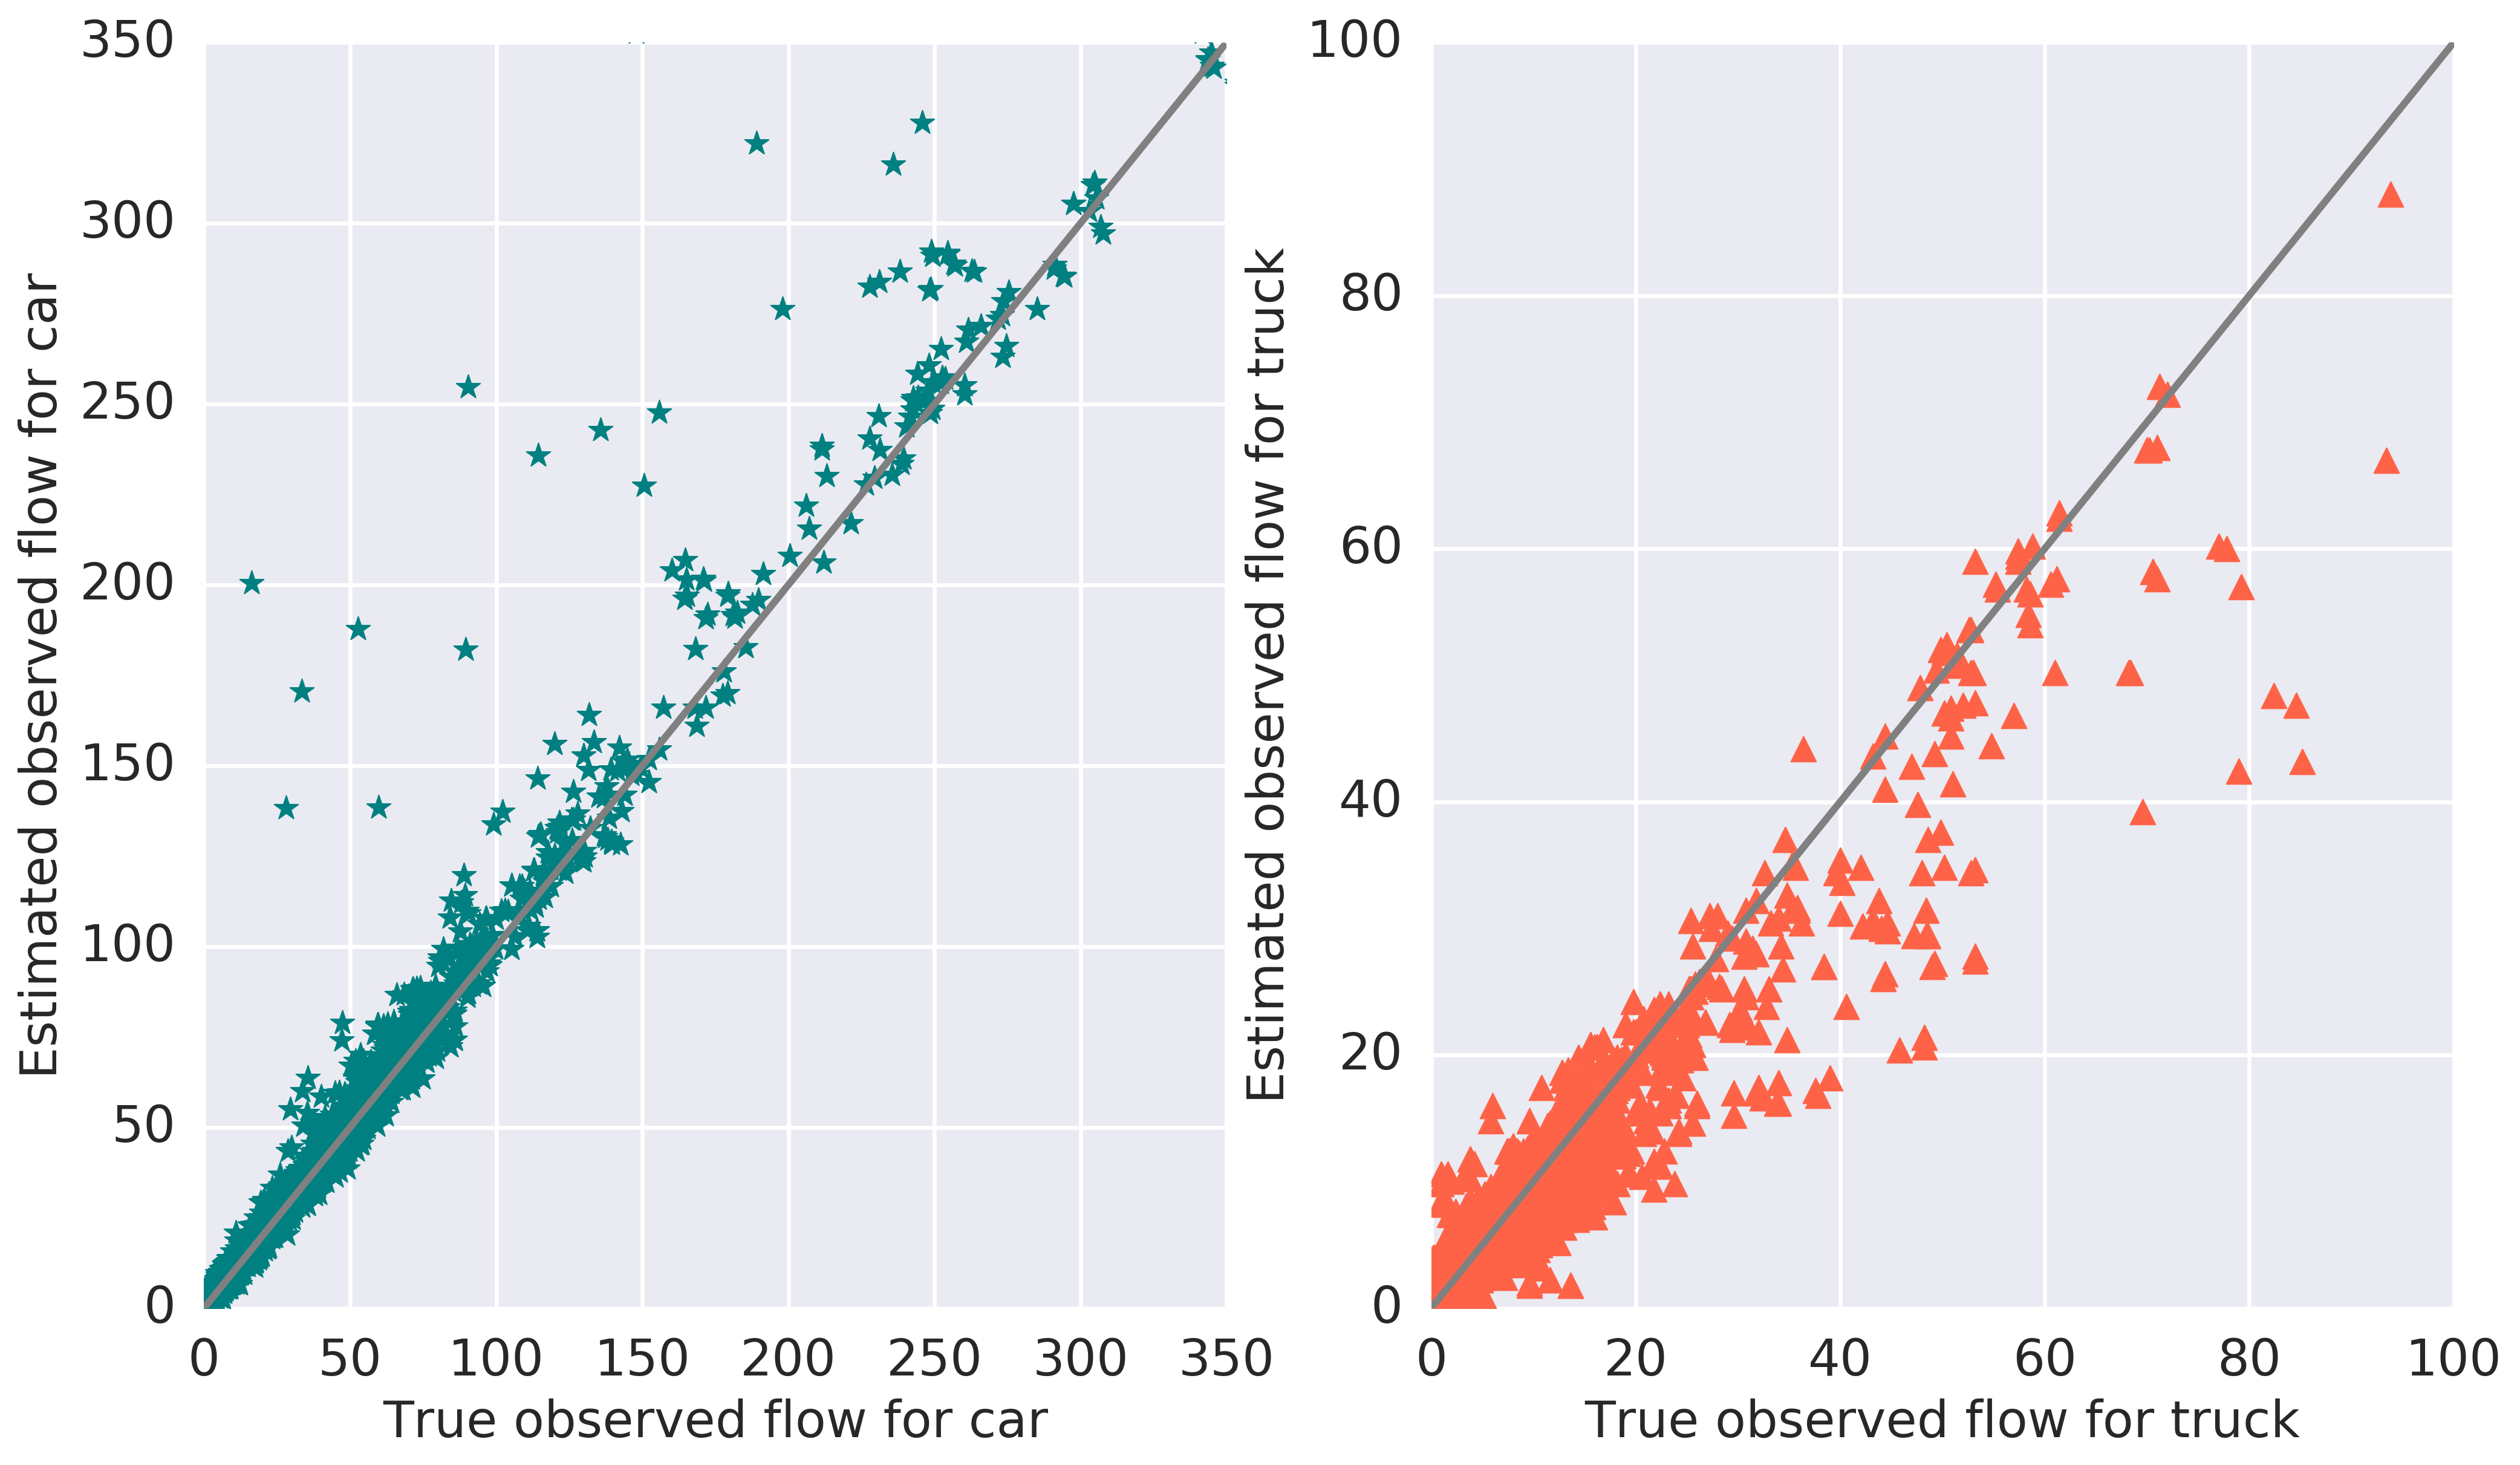

In [32]:
fig, axes = plt.subplots(1,2,  figsize=(16, 9), dpi=300)
# plt.figure(num=None, figsize=(16, 9), dpi=300, facecolor='w', edgecolor='k')
axes[0].scatter(m_car, L_car.dot(estimated_car_x), label = "Proposed direct solution", 
                color = 'teal', marker = '*', s = 100)
axes[0].plot(range(350), range(350), label = "Convex optimization solution", color = 'gray')
axes[1].scatter(m_truck, L_truck.dot(estimated_truck_x), label = "Proposed closed-form method", color = 'tomato', 
                marker = "^", s = 100)
axes[1].plot(range(350), range(350), label = "Convex optimization solution", color = 'gray')

axes[0].set_ylabel('Estimated observed flow for car')
axes[0].set_xlabel('True observed flow for car')
axes[1].set_ylabel('Estimated observed flow for truck')
axes[1].set_xlabel('True observed flow for truck')
axes[0].set_xlim([0, 350])
axes[0].set_ylim([0, 350])
axes[1].set_xlim([0, 100])
axes[1].set_ylim([0, 100])
plt.show()

In [30]:
e_m_truck =L_truck.dot(estimated_truck_x)
print r2_score(m_car, L_car.dot(estimated_car_x))
print r2_score(m_truck, e_m_truck)

0.9605180094251846
0.9091980458013711


In [31]:
e_m_truck =L_truck.dot(estimated_truck_x)
print r2(m_car, L_car.dot(estimated_car_x))
print r2(m_truck, e_m_truck)

0.9753532273474816
0.9117207660672388
